In [1]:
import torch
import torch.nn as nn
import timm
from tqdm import tqdm
import methods
import os
from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import json
from io import BytesIO
import requests
from copy import deepcopy
from astropy.nddata import Cutout2D
from torch.nn.utils.rnn import pad_sequence
from itertools import chain
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from scipy import stats
from sklearn.ensemble import IsolationForest

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim # latent space size
        hidden_dims = [16, 32, 64] # num of filters in layers
        modules = []
        in_channels = 1 # initial value of channels
        for h_dim in hidden_dims: # conv layers
            modules.append(
                nn.Sequential(
                    nn.Conv2d(                    
                        in_channels=in_channels, # num of input channels 
                        out_channels=h_dim, # num of output channels 
                        kernel_size=3, 
                        stride=2, # convolution kernel step
                        padding=1, # save shape
                        bias=False,
                    ),
                    nn.BatchNorm2d(h_dim),  
                    nn.LeakyReLU(), 
                )
            )
            in_channels = h_dim # changing number of input channels for next iteration

 
        modules.append(nn.Flatten()) # to vector, size 512 * 2*2 = 2048
        modules.append(nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)) 

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [64, 32, 16] # num of filters in layers
        self.linear = nn.Linear(in_features=latent_dim, out_features=hidden_dims[0]*4*4) 

        modules = []
        for i in range(len(hidden_dims) - 1): # define ConvTransopse layers
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels=hidden_dims[i],
                        out_channels=hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                        bias=False,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels=hidden_dims[-1],
                    out_channels=hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.ReLU(),
                #nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x) # from latents space to Linear 
        x = x.view(-1, 64, 4, 4) # reshape
        x = self.decoder(x) # reconstruction
        return x

## Из лекции

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim # latent space size
        hidden_dims = [32, 64, 128, 256, 512] # num of filters in layers
        modules = []
        in_channels = 1 # initial value of channels
        for h_dim in hidden_dims[:-1]: # conv layers
            modules.append(
                nn.Sequential(
                    nn.Conv2d(                    
                        in_channels=in_channels, # num of input channels 
                        out_channels=h_dim, # num of output channels 
                        kernel_size=3, 
                        stride=2, # convolution kernel step
                        padding=1, # save shape 
                        bias=False,
                    ),
                    nn.BatchNorm2d(h_dim),  
                    nn.LeakyReLU(), 
                )
            )
            in_channels = h_dim # changing number of input channels for next iteration

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, bias=False), # changing the kernel size, because  size of the array (2*2)
                nn.BatchNorm2d(512),
                nn.LeakyReLU(),
            )
        )
        modules.append(nn.Flatten()) # to vector, size 512 * 2*2 = 2048
        modules.append(nn.Linear(512 * 2 * 2, latent_dim)) 

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32] # num of filters in layers
        self.linear = nn.Linear(in_features=latent_dim, out_features=512) 

        modules = []
        for i in range(len(hidden_dims) - 1): # define ConvTransopse layers
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels=hidden_dims[i],
                        out_channels=hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                        bias=False,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels=hidden_dims[-1],
                    out_channels=hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.ReLU(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x) # from latents space to Linear 
        x = x.view(-1, 512, 1, 1) # reshape
        x = self.decoder(x) # reconstruction
        return x

################################################

In [4]:

'''
Function to train model, parameters: 
  enc - encoder
  dec - decoder
  loader - loader of data
  optimizer - optimizer
  single_pass_handler - return reconstructed image, use for loss 
  loss_handler - loss function 
  epoch - num of epochs
  '''


def train(
    enc,
    dec,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
):

    ep_loss = 0
    for batch_idx, data in enumerate(loader): 
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)

        latent, output = single_pass_handler(encoder, decoder, data) # reconstructed image drom decoder 

        loss = loss_handler(data, output, latent) # compute loss
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()
    return ep_loss / len(loader)

In [5]:
torch.manual_seed(42)

class VAEEncoder(Encoder):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0: # check for the parity of the latent space
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_dim)


def vae_split(latent):
    size = latent.shape[1] // 2 # divide the latent representation into mu and log_var
    mu = latent[:, :size] 
    log_var = latent[:, size:]  
    return mu, log_var


def vae_reparametrize(mu, log_var): 
    sigma = torch.exp(0.5 * log_var) 
    z = torch.randn(mu.shape[0], mu.shape[1]).to(device) 
    return z * sigma + mu 


def vae_pass_handler(encoder, decoder, data, *args, **kwargs): 
    latent = encoder(data) 
    mu, log_var = vae_split(latent) 
    sample = vae_reparametrize(mu, log_var) 
    recon = decoder(sample)
    return latent, recon


def kld_loss(mu, log_var): 
    var = log_var.exp()
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - var, dim=1), dim=0)
    return kl_loss


class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))



def vae_loss_handler(data, recons, latent, kld_weight=8e-5, *args, **kwargs):
    mu, log_var = vae_split(latent)
    kl_loss = kld_loss(mu, log_var)
    return kld_weight * kl_loss + LogCoshLoss()(recons, data) #F.mse_loss(recons, data)

In [6]:
'''
Function return transforms results to numpy for visualization 

encoder - encoder
decoder - decoder
loader - loader of data
single_pass_handler - return latent and reconstruction transform
return_real - return original images, True/False, default = True
return_recon - return transformed image from decoder, True/False, default = True
return_latent - return latent representation from encoder, True/False, default = True
return_labels - return labels, True/False, default = True
'''
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recon=True,
    return_latent=True,
):

    if return_real:
        real = []
    if return_recon:
        reconstr = []
    if return_latent:
        latent = []
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            if return_real:
                real.append(data.numpy())
         
            data = data.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data)
            
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recon:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recon:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    return result

In [7]:
def plot_manifold(latent_r, labels=None, alpha=0.9, title=None):
    plt.figure(figsize=(10, 10))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=alpha)
        if title:
            plt.title(title)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        plt.colorbar()
        if title:
            plt.title(title)
    plt.show()





def plot_imgs(*args, img_size=28, name=None, single_size=2): #, invert_colors=True
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.ones(((img_size + 1) * len(args) + 1, (img_size + 1) * n + 1))*np.max(args)

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * img_size + (j + 1): (j + 1) * img_size + (j + 1),
                i * img_size + (i + 1) : (i + 1) * img_size + (i + 1),
            ] = args[j][i].squeeze()

    #if invert_colors:
    #    figure = 1 - figure

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="gray")

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name, dpi=400, format='png', bbox_inches="tight")
    plt.show()

In [8]:
oids, targets = methods.get_only_r_oids('akb.ztf.snad.space.json')

In [9]:
torch.manual_seed(42)
frames_dataset = methods.AllFramesDataset(oids)
x_train, _ = random_split(frames_dataset, [0.01, 0.99])
train_loader = DataLoader(x_train, batch_size=64, shuffle=True)

## обучение

In [44]:
torch.manual_seed(42)

latent_dim = 36

learning_rate = 5e-5
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = torch.optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)

losses = []
for i in tqdm(range(1, 6)):
    losses.append(
        train(
            enc=encoder,
            dec=decoder,
            optimizer=optimizer,
            loader=train_loader,
            epoch=i,
            single_pass_handler=vae_pass_handler,
            loss_handler=vae_loss_handler,
        )
    )

 20%|█████████                                    | 1/5 [00:32<02:09, 32.30s/it]


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 264, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: torch.cat(): input types can't be cast to the desired output type Long


## загрузка обученной модели

In [10]:
latent_dim = 36

encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

encoder.load_state_dict(torch.load('trained_models/vae/encoder_bs256.zip'))
decoder.load_state_dict(torch.load('trained_models/vae/decoder_bs256.zip'))

<All keys matched successfully>

In [11]:
encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()

In [12]:
for seq in decoder.decoder.children():
    for child in seq.children():
        if isinstance(child, nn.BatchNorm2d):
            print(child.track_running_stats)

True
True
True
True
True


In [13]:
run_res = run_eval(encoder, decoder, train_loader, vae_pass_handler)

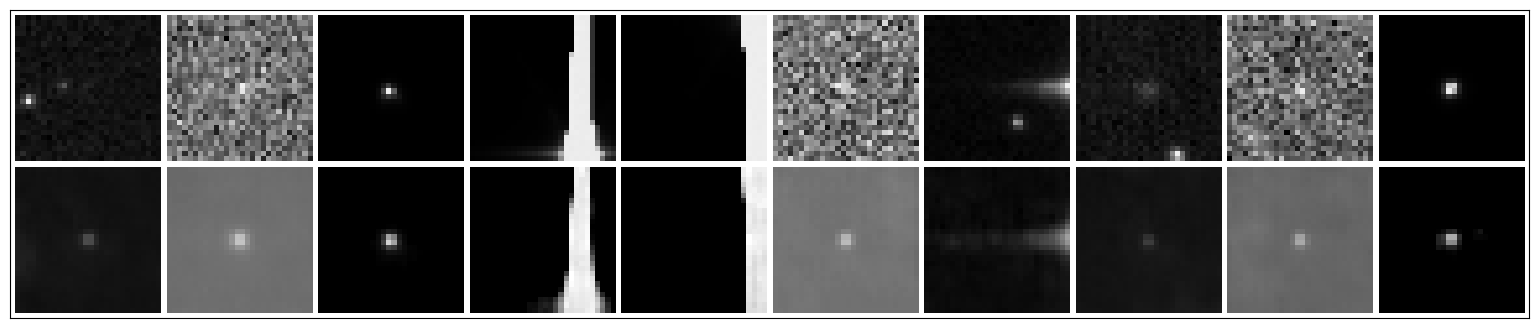

In [14]:
plot_imgs(run_res['real'][100:110], run_res['reconstr'][100:110])

In [15]:
X = run_res['latent'][:, :latent_dim]
isfor = IsolationForest(random_state=0).fit(X)
pred = isfor.predict(X)

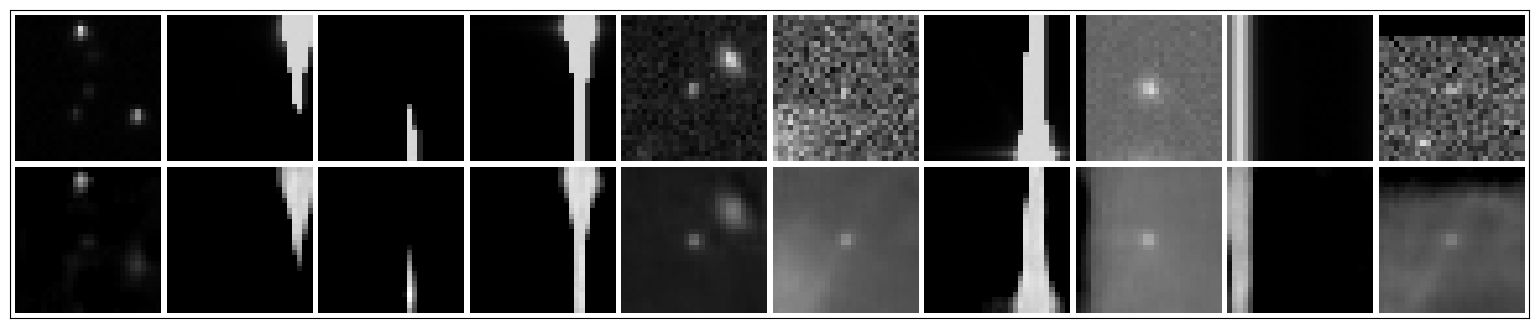

In [16]:
outliers = (pred == -1)
plot_imgs(run_res['real'][outliers][:10], run_res['reconstr'][outliers][:10])

In [17]:
sum(pred == -1)

902

In [18]:
mu, log_var = vae_split(run_res['latent'])
sigma = np.exp(0.5 * log_var)


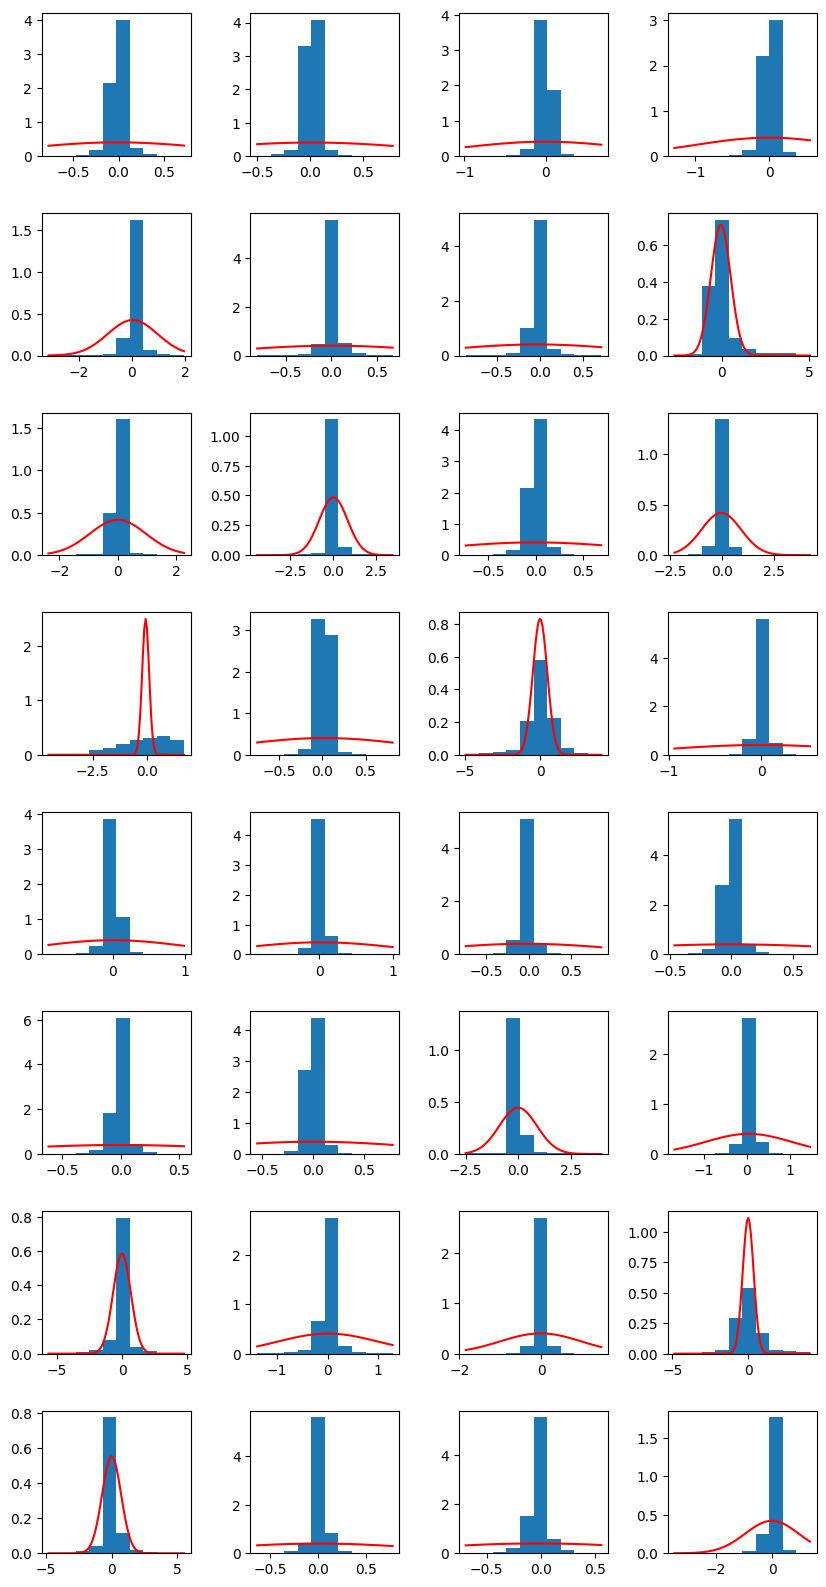

In [40]:
fig, axs = plt.subplots(8, 4, figsize=(10, 20))
for row in range(8):
    for col in range(4):
        axs[row][col].hist(mu[:, row*4+col], density=True)
        x = np.linspace(np.min(mu[:, row*4+col]), np.max(mu[:, row*4+col]), 100)
        pdf = stats.norm.pdf(x, np.mean(mu[:,  row*4+col]), np.mean(sigma[:, row*4+col]))
        axs[row][col].plot(x, pdf, c='red')

plt.subplots_adjust(
                    wspace=0.4,
                    hspace=0.4)

In [42]:
fig.savefig('visualizations/latent_dist', dpi=400, bbox_inches="tight")

## Visualization

In [26]:
latent_dim = 36

learning_rate = 5e-5
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)


In [20]:
encoder

VAEEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1024, out_features=72, bias=True)
  )
)

In [11]:
for batch in train_loader:
    y_enc = encoder(batch.to(device))
    break

mu, log_var = vae_split(y_enc)
sample = vae_reparametrize(mu, log_var) 
y_dec = decoder(sample)


In [28]:
input_name = ["Images"]
output_name = ["Latent state"]

torch.onnx.export(encoder.to('cpu'), batch, "encoder.onnx", input_names=input_name, output_names=output_name)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ValueError: expected 4D input (got 3D input)

In [16]:
input_name = ["Latent state"]
output_name = ["Reconstructed image"]

torch.onnx.export(decoder.to('cpu'), sample.to('cpu'), "decoder.onnx", input_names=input_name, output_names=output_name)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## MNIST

In [8]:
import torchvision.datasets as dset
import torchvision

train_set = dset.MNIST(
    root='mnist', train=True, transform=torchvision.transforms.ToTensor(), download=False
)

torch.manual_seed(42)

x_train, _ = random_split(train_set, [0.2, 0.8])

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    x_train, batch_size=batch_size, shuffle=True
)

In [9]:
def train(
    enc,
    dec,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):

    for batch_idx, (data, lab) in enumerate(loader): 
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)
        lab = lab.to(device)

        latent, output = single_pass_handler(encoder, decoder, data, lab) # reconstructed image drom decoder 

        loss = loss_handler(data, output, latent) # compute loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                ).ljust(40), 
                "Loss: {:.6f}".format(loss.item())
            )

            
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recon=True,
    return_latent=True,
    return_labels=True,
):

    if return_real:
        real = []
    if return_recon:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(loader):
            if return_labels:
                labels.append(label.numpy())
            if return_real:
                real.append(data.numpy())
         
            data = data.to(device)
            label = label.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, label)
            
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recon:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recon:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result["labels"] = labels
    return result

In [11]:
torch.manual_seed(42)

latent_dim = 24

learning_rate = 5e-4
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

device='cpu'
encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = torch.optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
for i in tqdm(range(1, 6)):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=30,
    )

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/12000 (0%)]            Loss: 0.053875
Train Epoch: 1 [1920/12000 (16%)]        Loss: 0.046904
Train Epoch: 1 [3840/12000 (32%)]        Loss: 0.047910
Train Epoch: 1 [5760/12000 (48%)]        Loss: 0.035066
Train Epoch: 1 [7680/12000 (64%)]        Loss: 0.019240
Train Epoch: 1 [9600/12000 (80%)]        Loss: 0.015134
Train Epoch: 1 [11520/12000 (96%)]       Loss: 0.015612


 20%|█████████                                    | 1/5 [00:38<02:34, 38.71s/it]

Train Epoch: 2 [0/12000 (0%)]            Loss: 0.013852
Train Epoch: 2 [1920/12000 (16%)]        Loss: 0.011990
Train Epoch: 2 [3840/12000 (32%)]        Loss: 0.011986
Train Epoch: 2 [5760/12000 (48%)]        Loss: 0.012047
Train Epoch: 2 [7680/12000 (64%)]        Loss: 0.011215
Train Epoch: 2 [9600/12000 (80%)]        Loss: 0.011232
Train Epoch: 2 [11520/12000 (96%)]       Loss: 0.010463


 40%|██████████████████                           | 2/5 [01:19<02:00, 40.00s/it]

Train Epoch: 3 [0/12000 (0%)]            Loss: 0.010273
Train Epoch: 3 [1920/12000 (16%)]        Loss: 0.011011
Train Epoch: 3 [3840/12000 (32%)]        Loss: 0.010472
Train Epoch: 3 [5760/12000 (48%)]        Loss: 0.010421
Train Epoch: 3 [7680/12000 (64%)]        Loss: 0.010178
Train Epoch: 3 [9600/12000 (80%)]        Loss: 0.009139
Train Epoch: 3 [11520/12000 (96%)]       Loss: 0.010391


 60%|███████████████████████████                  | 3/5 [01:59<01:19, 39.88s/it]

Train Epoch: 4 [0/12000 (0%)]            Loss: 0.009793
Train Epoch: 4 [1920/12000 (16%)]        Loss: 0.009506
Train Epoch: 4 [3840/12000 (32%)]        Loss: 0.010415
Train Epoch: 4 [5760/12000 (48%)]        Loss: 0.009180
Train Epoch: 4 [7680/12000 (64%)]        Loss: 0.009352
Train Epoch: 4 [9600/12000 (80%)]        Loss: 0.009725
Train Epoch: 4 [11520/12000 (96%)]       Loss: 0.009374


 80%|████████████████████████████████████         | 4/5 [02:38<00:39, 39.64s/it]

Train Epoch: 5 [0/12000 (0%)]            Loss: 0.009317
Train Epoch: 5 [1920/12000 (16%)]        Loss: 0.009546
Train Epoch: 5 [3840/12000 (32%)]        Loss: 0.010033
Train Epoch: 5 [5760/12000 (48%)]        Loss: 0.009333
Train Epoch: 5 [7680/12000 (64%)]        Loss: 0.009211
Train Epoch: 5 [9600/12000 (80%)]        Loss: 0.009061
Train Epoch: 5 [11520/12000 (96%)]       Loss: 0.008679


100%|█████████████████████████████████████████████| 5/5 [03:15<00:00, 39.09s/it]


In [12]:
encoder = encoder.eval()
decoder = decoder.eval()

In [13]:
run_res = run_eval(encoder, decoder, train_loader, vae_pass_handler)

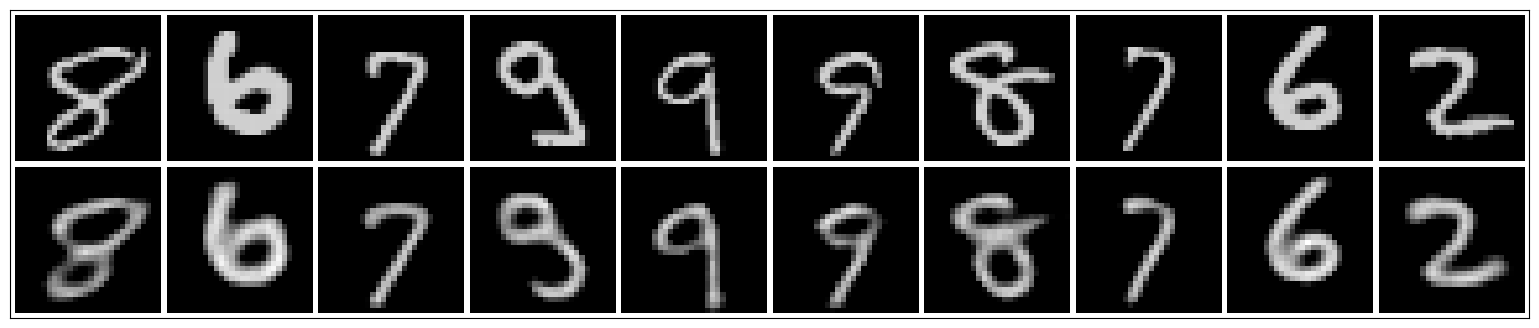

In [14]:
plot_imgs(run_res['real'][100:110], run_res['reconstr'][100:110])

In [15]:
mu, log_var = vae_split(run_res['latent'])
sigma = np.exp(0.5 * log_var)


(array([  29.,  345., 1038., 1607., 2244., 2803., 2431., 1147.,  310.,
          46.]),
 array([-3.79015112, -3.06909847, -2.34804606, -1.62699342, -0.90594083,
        -0.18488824,  0.53616434,  1.25721693,  1.97826946,  2.69932199,
         3.42037463]),
 <BarContainer object of 10 artists>)

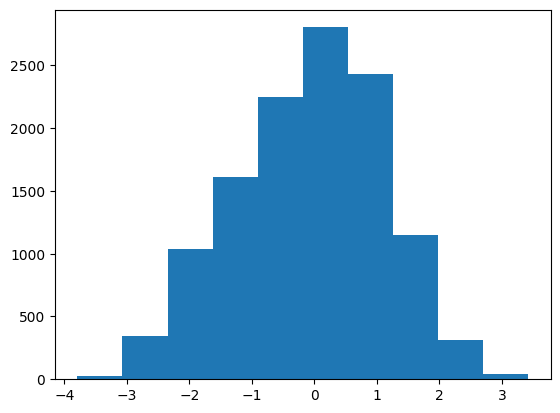

In [16]:
plt.hist(mu[:,1])